# Intra-Annual Sea Level Rankings
```{glue:figure} top_10_per_month
:align: left
```
In this notebook we'll explore sea level rankings on an intra-annual scale.

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called [setup](notebooks/setup.ipynb) and import our plotting functions, which will also set our data and output paths. If you have not run the [datawrangling notebook](notebooks/SL_Data_Wrangling.ipynb), you will need to do this before running this notebook. Note that this notebook is also largely a repeat of the [anomaly](notebooks/regional_and_local/SL_anomaly_annual.ipynb) notebook. 

In [1]:
%run ../setup.ipynb

import plotly.io as pio
import calendar

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in '+ str(data_dir) +  '. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in '+ str(data_dir) +  '. Proceed.')

rsl_hawaii.nc found in /Users/jfiedler/Documents/SL_Hawaii_data/data. Proceed.


Import the sea level data that we've already processed.

In [2]:
#import rsl_daily
rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii_noaa.nc')
rsl_hourly['sea_level_mhhw'] = rsl_hourly['sea_level'] - rsl_hourly['MHHW']

In [3]:
# make dict of station ID to station name
station_dict = {stid: rsl_hourly['station_name'].sel(station_id=stid).values.item() for stid in rsl_hourly['station_id'].values}

# output this prettily
for stid, name in station_dict.items():
    print(f'Station ID: {stid}, Name: {name}')

Station ID: 1617760, Name: Hilo, Hilo Bay, Kuhio Bay
Station ID: 1619910, Name: Sand Island, Midway Islands
Station ID: 1617433, Name: Kawaihae
Station ID: 1612480, Name: Mokuoloe
Station ID: 1615680, Name: Kahului, Kahului Harbor
Station ID: 1612340, Name: Honolulu
Station ID: 1611400, Name: Nawiliwili


In [4]:
#choose a station
station_id = '1612340'

Define a function to retrieve the top (or bottom) 10 events by month and by station, using the sea level (m, MHHW) variable we just created in rsl_hourly

In [5]:
def get_top_ten(rsl_subset, station_id, month, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl_subset.sea_level_mhhw.sel(station_id=station_id).where(rsl_hourly['time.month'] == month, drop=True).to_series()

   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 10:
            break
    rank = np.arange(1,11)

    station_name = str(rsl_subset['station_name'].sel(station_id=str(station_id)).values)

    top_10_values = pd.DataFrame({'rank in month': rank, 'date': top_10_values.index, 'month': month, 'sea level (m, MHHW)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['station_id'] = station_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

In [6]:
# get the top ten highest hourly sea level values for each station
top_ten_values = pd.DataFrame()
for month in range(1,13):
    top_ten_values = pd.concat([top_ten_values, get_top_ten(rsl_hourly, station_id=station_id, month=month, mode='max')])

In [7]:
top_ten_values

,rank in month,date,month,"sea level (m, MHHW)",station_name,station_id,type
0,1,1974-01-08 14:00:00,1,0.359,Honolulu,1612340,max
1,2,1969-01-17 14:00:00,1,0.356,Honolulu,1612340,max
2,3,2018-01-29 13:00:00,1,0.338,Honolulu,1612340,max
3,4,2020-01-11 15:00:00,1,0.335,Honolulu,1612340,max
4,5,2018-01-01 14:00:00,1,0.329,Honolulu,1612340,max
...,...,...,...,...,...,...,...
5,6,2019-12-13 15:00:00,12,0.356,Honolulu,1612340,max
6,7,1995-12-22 14:00:00,12,0.344,Honolulu,1612340,max
7,8,1984-12-23 15:00:00,12,0.335,Honolulu,1612340,max
8,9,1987-12-20 14:00:00,12,0.329,Honolulu,1612340,max


In [8]:
# save to csv
savename = 'top_ten_hourly_sea_level_by_month_'+ station_id + '.csv'
savepath = data_dir / savename
top_ten_values.to_csv(savename, index=False)


In [9]:
# resample to monthly max
monthly_max = rsl_hourly.sel(station_id=station_id).resample(time='1MS').max()
mean_monthly_max = monthly_max['sea_level_mhhw'].groupby('time.month').mean()
mean_monthly_max = mean_monthly_max.to_series()

# add average between jan/dec at beginning and end of series for plotting
mean_monthly_max_ext = pd.concat([pd.Series({0: (mean_monthly_max[1]+mean_monthly_max[12])/2}), mean_monthly_max, pd.Series({13: (mean_monthly_max[1]+mean_monthly_max[12])/2})])
mean_monthly_max_ext = mean_monthly_max_ext.sort_index()



## Make a Plot

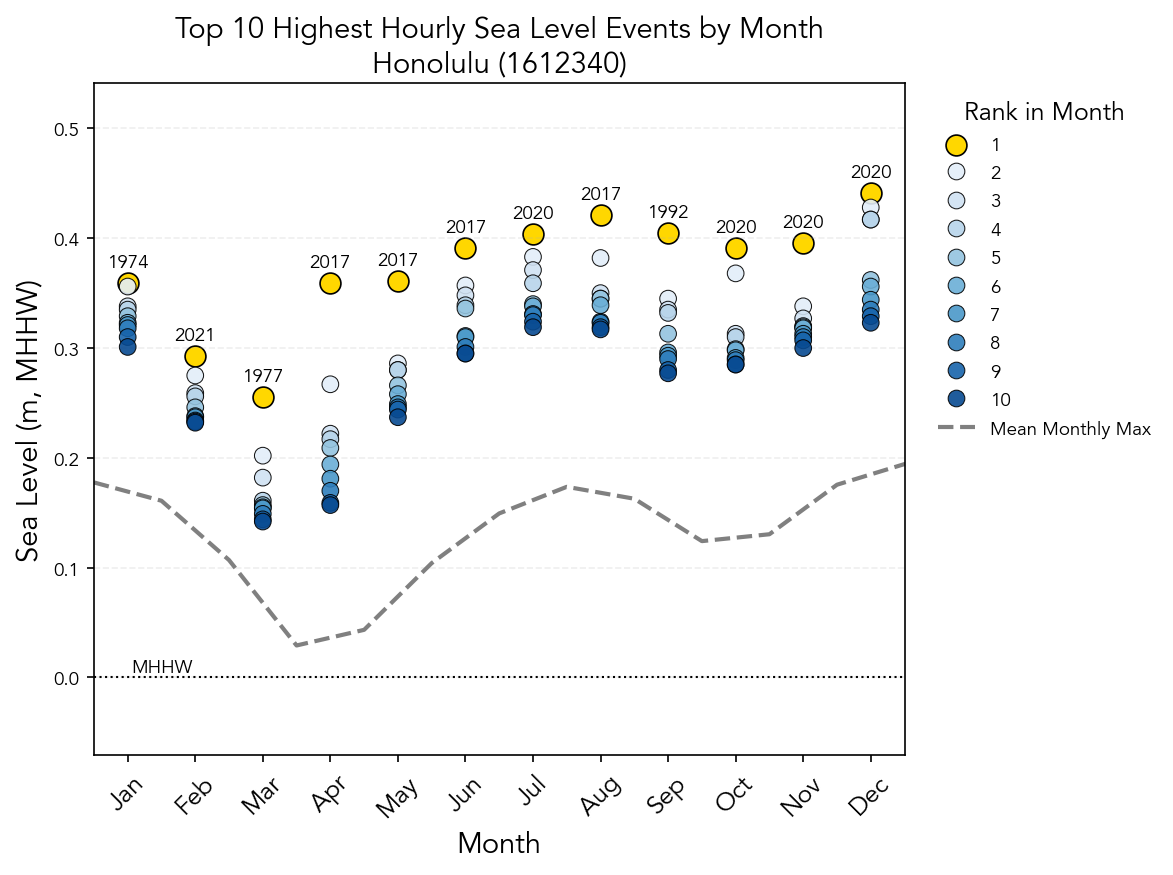

In [19]:
# Add month names
df = top_ten_values.copy()
df["month_name"] = df["month"].apply(lambda x: calendar.month_abbr[x])

# Make ranks categorical so Seaborn treats them as discrete (not continuous)
df["rank_str"] = df["rank in month"].astype(int).astype(str)
hue_order = [str(i) for i in range(2, 11)]  # '2'..'10'


fig, ax = plt.subplots(figsize=(8, 6))


ax.scatter(
    x=df[df["rank in month"] == 1]["month_name"],
    y=df[df["rank in month"] == 1]["sea level (m, MHHW)"],
    color="gold",
    edgecolor="black",
    linewidth=0.8,
    label="1",
    s=100
)

# Plot ranks 2–10 in light blue
sns.stripplot(
    data=df[df["rank in month"] > 1],
    x="month_name",
    y="sea level (m, MHHW)",
    hue="rank_str",
    palette="Blues",
    size=8,
    jitter=False,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# add mean monthly max line
ax.plot(
    mean_monthly_max_ext.index-0.5,
    mean_monthly_max_ext.values,
    color="gray",
    linestyle="--",
    linewidth=2,
    label="Mean Monthly Max"
)

# Annotate rank 1 points with date
for _, row in df[df["rank in month"] == 1].iterrows():
    ax.text(
        row["month_name"],
        row["sea level (m, MHHW)"] + 0.01,  # Slightly above the point
        row["date"].strftime("%Y"),
        fontsize=9,
        ha="center",
        va="bottom",
        rotation=0
    )

# add horizontal line at y=0 for MHHW, annotate
ax.axhline(0, color='black', linestyle=':', linewidth=1)
ax.text(0.5, 0, "MHHW", fontsize=9, ha="center", va="bottom")

# Styling
ax.set_title(f"Top 10 Highest Hourly Sea Level Events by Month\n{df['station_name'].iloc[0]} ({df['station_id'].iloc[0]})", fontsize=14)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Sea Level (m, MHHW)", fontsize=14)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(rotation=45, fontsize=12, labels=calendar.month_abbr[1:13])
# ax.set_yticklabels(fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, title="Rank in Month", title_fontsize=12)
ax.grid(axis="y", alpha=0.2, linestyle="--")

# set x-limits to show all months
ax.set_xlim(-0.5, 11.5)

# set ylim[1] to be 0.1 m higher than the highest point
ax.set_ylim(bottom=mean_monthly_max_ext.min()-0.1, top=df["sea level (m, MHHW)"].max()+0.1)

# don't cut off the legend, set fig to tight layout
fig.tight_layout()


# save figure
savename = 'SL_Rankings_intra_annual_'+df['station_name'].iloc[0].replace(' ', '_')+'_'+df['station_id'].iloc[0]+'.png'

fig.savefig(output_dir / savename, dpi=300)

glue("top_10_per_month", fig,display=False)


```{glue:figure} top_10_per_month
:name: "top_10_per_month"

Top 10 highest observed sea levels by month, relative to MHHW. Highest ranked events by month are shown in yellow circles, with their respective years annotated. The mean of the monthly maxima for all time is shown in the dashed bold line.
```

## Make a table

In [11]:
# make a great tables table
from great_tables import GT, md, html
station_name = rsl_hourly['station_name'].sel(station_id=station_id).values

# work on a copy
sub = df[df["rank in month"] <= 5].copy()
sub["Date"] = pd.to_datetime(sub["date"]).dt.strftime("%Y-%m-%d")
sub["Sea Level (cm, MHHW)"] = sub["sea level (m, MHHW)"].round(3)*100

# Pivot into separate tables (rows = Rank, cols = Month num)
dates = sub.pivot(index="rank in month", columns="month", values="Date")
seas  = sub.pivot(index="rank in month", columns="month", values="Sea Level (cm, MHHW)")

# --- stack with keys; we want Sea first, then Date ---
stacked = (
    pd.concat([seas, dates], keys=["Sea Level (cm, MHHW)", "Date"])
      .swaplevel(0, 1)  # rows index now: (rank in month, Field)
)

# Force custom order on the Field level so sorting yields: Sea, Date
field_order = ["Sea Level (cm, MHHW)", "Date"]
lvl0, lvl1 = stacked.index.levels
stacked.index = stacked.index.set_levels(
    [lvl0, pd.CategoricalIndex(lvl1, categories=field_order, ordered=True)],
    level=[0, 1]
)

# Now sort by rank, then Field (respecting our custom order)
stacked = stacked.sort_index(level=[0, 1])

# --- columns Jan..Dec, then prettify to month abbr ---
month_order = list(range(1, 13))
stacked = stacked.reindex(columns=month_order)
stacked.columns = [calendar.month_abbr[m] for m in stacked.columns]

# --- flatten rows (drop the Field label so rows alternate Sea/Date per Rank) ---
table_df = (
    stacked.reset_index()
           .drop(columns="level_1")                 # remove Field column
           .rename(columns={"rank in month": "Rank"})
)

# Take a peak at the data:
table_df.head(12)

,Rank,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,35.9,29.3,25.5,35.9,36.1,39.1,40.4,42.1,40.5,39.1,39.6,44.1
1,1,1974-01-08,2021-02-10,1977-03-25,2017-04-29,2017-05-26,2017-06-24,2020-07-20,2017-08-21,1992-09-12,2020-10-19,2020-11-15,2020-12-15
2,2,35.6,27.5,20.2,26.7,28.6,35.7,38.3,38.2,34.5,36.8,33.8,42.8
3,2,1969-01-17,2018-02-01,2017-03-09,2017-04-26,2017-05-01,2003-06-14,2020-07-05,2019-08-02,2003-09-24,2024-10-18,1984-11-24,2019-12-25
4,3,33.8,25.9,18.2,22.2,28.0,34.8,37.1,35.0,33.5,31.3,32.7,41.7
5,3,2018-01-29,2020-02-09,2005-03-08,1995-04-18,1988-05-31,2004-06-04,2024-07-21,2024-08-20,2020-09-15,2003-10-26,2024-11-16,1968-12-19
6,4,33.5,25.6,16.1,21.7,28.0,33.9,35.9,34.5,33.2,31.0,32.0,41.7
7,4,2020-01-11,2017-02-09,1993-03-05,2021-04-29,2004-05-08,2020-06-05,1995-07-11,2020-08-02,2024-09-16,2023-10-30,2004-11-13,2021-12-05
8,5,32.9,24.6,15.7,20.9,26.6,33.6,34.0,34.5,31.3,29.9,31.9,36.2
9,5,2018-01-01,2016-02-09,2021-03-09,2020-04-11,2016-05-08,2016-06-06,2008-07-31,2020-08-20,2003-09-09,2016-10-18,2007-11-25,2024-12-15


Add the mean monthly max on to the table for display:

In [12]:
# Start with the label
mean_row = {"Rank": "Mean Monthly Max"}

# Add each month abbreviation + its mean
for m in range(1, 13):
    mean_row[calendar.month_abbr[m]] = round(mean_monthly_max.loc[m], 3)*100  # convert to cm

# Convert to DataFrame
mean_row = pd.DataFrame([mean_row])

# Append to bottom (or top) of your table
table_df = pd.concat([table_df, mean_row], ignore_index=True)

In [13]:
table_df

,Rank,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,35.9,29.3,25.5,35.9,36.1,39.1,40.4,42.1,40.5,39.1,39.6,44.1
1,1,1974-01-08,2021-02-10,1977-03-25,2017-04-29,2017-05-26,2017-06-24,2020-07-20,2017-08-21,1992-09-12,2020-10-19,2020-11-15,2020-12-15
2,2,35.6,27.5,20.2,26.7,28.6,35.7,38.3,38.2,34.5,36.8,33.8,42.8
3,2,1969-01-17,2018-02-01,2017-03-09,2017-04-26,2017-05-01,2003-06-14,2020-07-05,2019-08-02,2003-09-24,2024-10-18,1984-11-24,2019-12-25
4,3,33.8,25.9,18.2,22.2,28.0,34.8,37.1,35.0,33.5,31.3,32.7,41.7
5,3,2018-01-29,2020-02-09,2005-03-08,1995-04-18,1988-05-31,2004-06-04,2024-07-21,2024-08-20,2020-09-15,2003-10-26,2024-11-16,1968-12-19
6,4,33.5,25.6,16.1,21.7,28.0,33.9,35.9,34.5,33.2,31.0,32.0,41.7
7,4,2020-01-11,2017-02-09,1993-03-05,2021-04-29,2004-05-08,2020-06-05,1995-07-11,2020-08-02,2024-09-16,2023-10-30,2004-11-13,2021-12-05
8,5,32.9,24.6,15.7,20.9,26.6,33.6,34.0,34.5,31.3,29.9,31.9,36.2
9,5,2018-01-01,2016-02-09,2021-03-09,2020-04-11,2016-05-08,2016-06-06,2008-07-31,2020-08-20,2003-09-09,2016-10-18,2007-11-25,2024-12-15


Now we'll make it pretty:

In [14]:
from great_tables import GT, style, md, html, loc,vals


date_mask = table_df.apply(lambda row: row.astype(str).str.contains("-").any(), axis=1)
sea_rows = table_df[table_df.iloc[:,1].apply(lambda x: str(x).replace('.','',1).isdigit())].index.tolist()
date_rows = table_df[date_mask].index.tolist()



table_fmt = table_df.copy()
# identify date rows: 0=Sea, 1=Date, 2=Sea, 3=Date, ...
date_rows = table_fmt.index % 2 == 1

# columns to format (all months, not "Rank")
month_cols = [c for c in table_fmt.columns if c != "Rank"]
mean_idx = table_df.index[-1]  # the last row 

def format_yr_mon_day(series):
    # parse to datetime (coerce errors to NaT so non-dates stay as-is)
    dt = pd.to_datetime(series, errors="coerce")
    # format like "2022<br>Jan 6" (no leading zero on day)
    # %-d works on Unix; Windows needs %#d. We'll do a portable strip:
    s_year = dt.dt.strftime("%Y")
    s_mday = dt.dt.strftime("%b %d").str.replace(r"\b0(\d)\b", r"\1", regex=True)
    out = s_year + "<br>" + s_mday
    # keep original where not a valid date (NaT)
    out = np.where(dt.notna(), out, series.astype(str))
    return out

# apply only to the date rows for each month column
for col in month_cols:
    table_fmt.loc[date_rows, col] = format_yr_mon_day(table_fmt.loc[date_rows, col])

table_fmt["Rank"] = table_fmt["Rank"].astype(str)
table_fmt.loc[date_rows, "Rank"] = ""   # or None

min_val = float(table_fmt.iloc[sea_rows, 1:].min().min())
max_val = float(table_fmt.iloc[sea_rows, 1:].max().max())

table_fmt.loc[mean_idx, "Rank"] = "Mean<br>Monthly Max"
# start table
table = GT(table_fmt)


table = (
    table.tab_header(title="Top 5 Sea Levels by Month", subtitle=f"Station: {station_name} ({station_id}), Units: cm, MHHW")
         # smaller text for date rows
         .tab_style(
             style=style.text(size="10px"),
             locations=loc.body(rows=[i for i in table_df.index if i not in sea_rows])
         )
         .tab_style(
             style=style.text(weight="bold"),
             locations=loc.body(rows=mean_idx)
         )
         .cols_align("center", columns=month_cols)
         # color scale applied only to sea-level rows
         .data_color(
             columns=[c for c in table_df.columns if c != "Rank"],  # skip rank
             rows=sea_rows,
             domain=[min_val, max_val],
             palette=["white", "lightblue"],
             na_color="white",
         )
         .fmt_number(columns=month_cols, rows=sea_rows, n_sigfig=3)
         .tab_source_note(source_note="Source: NOAA CO-OPS Hourly Water Level")
)

savename = f"top_5_hourly_sea_level_by_month_{station_id}_table.png"
savepath =  output_dir / savename
print(f"Saving table to {savepath}")
table.save(savepath,scale=2)  # scale=2 for high-DPI displays

# save as raw html too
savename = f"top_5_hourly_sea_level_by_month_{station_id}_table.html"
savepath =  output_dir / savename
table.write_raw_html(savepath)

table

Saving table to /Users/jfiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output/top_5_hourly_sea_level_by_month_1612340_table.png


GT(_tbl_data=                   Rank             Jan             Feb             Mar  \
0                     1            35.9            29.3            25.5   
1                         1974<br>Jan 8  2021<br>Feb 10  1977<br>Mar 25   
2                     2            35.6            27.5            20.2   
3                        1969<br>Jan 17   2018<br>Feb 1   2017<br>Mar 9   
4                     3            33.8            25.9            18.2   
5                        2018<br>Jan 29   2020<br>Feb 9   2005<br>Mar 8   
6                     4            33.5            25.6            16.1   
7                        2020<br>Jan 11   2017<br>Feb 9   1993<br>Mar 5   
8                     5            32.9            24.6            15.7   
9                         2018<br>Jan 1   2016<br>Feb 9   2021<br>Mar 9   
10  Mean<br>Monthly Max            16.1            10.7             2.9   

               Apr             May             Jun             Jul  \
0             35.9            36.1            39.1            40.4   
1   2017<br>Apr 29  2017<br>May 26  2017<br>Jun 24  2020<br>Jul 20   
2             26.7            28.6            35.7            38.3   
3   2017<br>Apr 26   2017<br>May 1  2003<br>Jun 14   2020<br>Jul 5   
4             22.2            28.0            34.8            37.1   
5   1995<br>Apr 18  1988<br>May 31   2004<br>Jun 4  2024<br>Jul 21   
6             21.7            28.0            33.9            35.9   
7   2021<br>Apr 29   2004<br>May 8   2020<br>Jun 5  1995<br>Jul 11   
8             20.9            26.6            33.6            34.0   
9   2020<br>Apr 11   2016<br>May 8   2016<br>Jun 6  2008<br>Jul 31   
10             4.3            10.4            14.9            17.4   

               Aug             Sep             Oct             Nov  \
0             42.1            40.5            39.1            39.6   
1   2017<br>Aug 21  1992<br>Sep 12  2020<br>Oct 19  2020<br>Nov 15   
2             38.2            34.5            36.8            33.8   
3    2019<br>Aug 2  2003<br>Sep 24  2024<br>Oct 18  1984<br>Nov 24   
4             35.0            33.5            31.3            32.7   
5   2024<br>Aug 20  2020<br>Sep 15  2003<br>Oct 26  2024<br>Nov 16   
6             34.5            33.2            31.0            32.0   
7    2020<br>Aug 2  2024<br>Sep 16  2023<br>Oct 30  2004<br>Nov 13   
8             34.5            31.3            29.9            31.9   
9   2020<br>Aug 20   2003<br>Sep 9  2016<br>Oct 18  2007<br>Nov 25   
10            16.3            12.4            13.0            17.6   

               Dec  
0             44.1  
1   2020<br>Dec 15  
2             42.8  
3   2019<br>Dec 25  
4             41.7  
5   1968<br>Dec 19  
6             41.7  
7    2021<br>Dec 5  
8             36.2  
9   2024<br>Dec 15  
10            19.4  , _body=<great_tables._gt_data.Body object at 0x31cb3c6e0>, _boxhead=Boxhead([ColInfo(var='Rank', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='left', column_width=None), ColInfo(var='Jan', type=<ColInfoTypeEnum.default: 1>, column_label='Jan', column_align='center', column_width=None), ColInfo(var='Feb', type=<ColInfoTypeEnum.default: 1>, column_label='Feb', column_align='center', column_width=None), ColInfo(var='Mar', type=<ColInfoTypeEnum.default: 1>, column_label='Mar', column_align='center', column_width=None), ColInfo(var='Apr', type=<ColInfoTypeEnum.default: 1>, column_label='Apr', column_align='center', column_width=None), ColInfo(var='May', type=<ColInfoTypeEnum.default: 1>, column_label='May', column_align='center', column_width=None), ColInfo(var='Jun', type=<ColInfoTypeEnum.default: 1>, column_label='Jun', column_align='center', column_width=None), ColInfo(var='Jul', type=<ColInfoTypeEnum.default: 1>, column_label='Jul', column_align='center', column_width=None), ColInfo(var='Aug', type=<ColInfoTypeEnum.default: 1>, column_label='Aug', column_align='center', column_width=None), ColInfo(var='Sep', typ

## Make a Map

In [15]:
# for each station, do the top ten function, but only return the rank 1 event for each month
rank1_events = pd.DataFrame()
for station in rsl_hourly['station_id'].values:
    for month in range(1,13):
        rank1_events = pd.concat([rank1_events, get_top_ten(rsl_hourly, station_id=station, month=month, mode='max').iloc[[0]]])    


Turn it into a dataset for easy plotting:

In [16]:
# turn rank1_events into an xarray dataset, with coordinates lat, lon, station_id, station_name, month
rank1_events_ds = rank1_events.set_index(['station_id', 'month']).to_xarray()

# drop rank in month, type
rank1_events_ds = rank1_events_ds.drop_vars(['rank in month', 'type'])

# station name var only has station_id as coord
rank1_events_ds['station_name'] = (('station_id'), rank1_events['station_name'].unique())

rank1_events_ds['lat'] = (('station_id'), [rsl_hourly['lat'].sel(station_id=stid).values for stid in rank1_events_ds['station_id'].values])
rank1_events_ds['lon'] = (('station_id'), [rsl_hourly['lon'].sel(station_id=stid).values for stid in rank1_events_ds['station_id'].values])

rank1_events_ds

<xarray.Dataset> Size: 2kB
Dimensions:              (station_id: 7, month: 12)
Coordinates:
  * station_id           (station_id) object 56B '1611400' ... '1619910'
  * month                (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    date                 (station_id, month) datetime64[ns] 672B 2022-01-15T1...
    sea level (m, MHHW)  (station_id, month) float64 672B 0.425 0.376 ... 0.775
    station_name         (station_id) object 56B 'Hilo, Hilo Bay, Kuhio Bay' ...
    lat                  (station_id) float64 56B 21.95 21.3 ... 19.73 28.21
    lon                  (station_id) float64 56B 200.6 202.1 ... 204.9 182.6

In [17]:
# drop Sand Island, Midway Island
rank1_events_ds = rank1_events_ds.drop_sel(station_id=['1619910'])

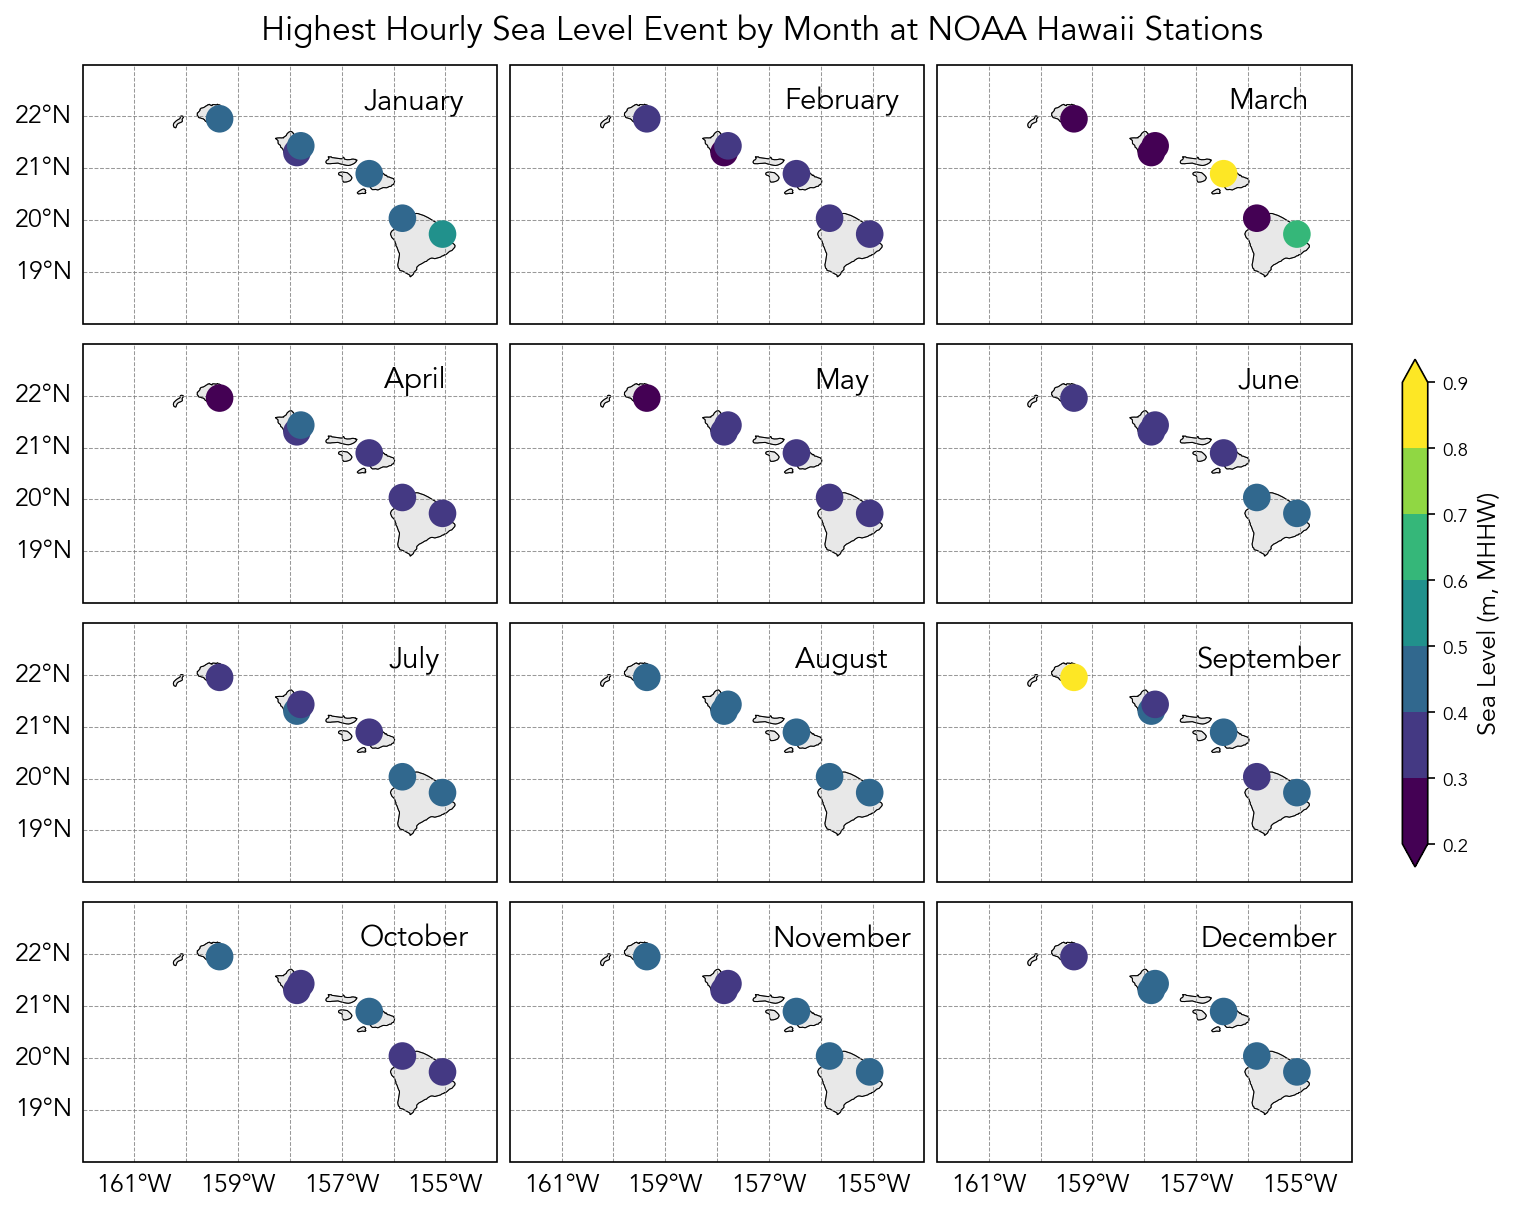

In [18]:
# make a 12 panel map, showing the locations of the rank 1 event for each month for each station
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap


# Define discrete boundaries
min_value = rank1_events_ds['sea level (m, MHHW)'].min()
max_value = rank1_events_ds['sea level (m, MHHW)'].max()
min_value, max_value = [0.2, 1]  # set min and max values for color scale
# create boundaries from min to max with interval of 0.1
boundcolors = np.arange(min_value, max_value, 0.1)  # Adjust boundaries as needed
cmap = plt.get_cmap('viridis', len(boundcolors) - 1)  # Create a discrete jet colormap
norm = BoundaryNorm(boundcolors, ncolors=cmap.N, clip=True)



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8),   
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                         constrained_layout=True)

months = [calendar.month_name[m] for m in range(1, 13)]


for i, ax in enumerate(axes.flat):
    month = i + 1
    month_data = rank1_events_ds.sel(month=month)
    sc = ax.scatter(
        month_data['lon'],
        month_data['lat'],
        c=month_data['sea level (m, MHHW)'],
        s=150,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray',linewidth=0.5,alpha=0.5)
    # ax.set_title(months[i], location='left', fontsize=14)
    ax.set_extent([198, 206, 18, 23])
    # add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # remove gl bottom labels if not in last row
    if i < 9:
        gl.bottom_labels = False
    # remove gl left labels if not in first column
    if i % 3 != 0:
        gl.left_labels = False

# add a colorbar to the right of the figure
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04,extend='both')
cbar.set_label('Sea Level (m, MHHW)', fontsize=12)
# cbar.ax.tick_params(labelsize=10)        

# set font to Avenir
plt.rcParams["font.family"] = "Avenir, Helvetica, Arial, sans-serif"

# add title to the figure
fig.suptitle('Highest Hourly Sea Level Event by Month at NOAA Hawaii Stations', fontsize=16)

# add month labels to each subplot
for i, ax in enumerate(axes.flat):
    month = i + 1
    ax.text(0.8, 0.8, months[i], transform=ax.transAxes, ha='center', va='bottom', fontsize=14)

# save figure
savename = 'SL_Rankings_intra_annual_map.png'
fig.savefig(output_dir / savename, dpi=300)